In [12]:
# Basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import time

# Classification models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Utilities and metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Preprocessing
import nltk
import re

# Download nltk resources
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rafael\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Exploração do Dataset

In [13]:
path = "../data/binary/"
df = pd.read_csv(path + 'IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Preprocessamento do Dataset

In [14]:
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'<.*?>', '', text) # remove html tags, frequently found in dataset
    text = re.sub(r'[^\w\s]', '', text)
    
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

df['review'] = df['review'].apply(preprocess_text)
df

,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,im going disagree previous comment side maltin...,negative


In [15]:
df = df.groupby('sentiment').apply(lambda x: x.sample(frac=1)).reset_index(drop=True)
df['sentiment'].value_counts()

C:\Users\Rafael\AppData\Local\Temp\ipykernel_25988\244846950.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('sentiment').apply(lambda x: x.sample(frac=1)).reset_index(drop=True)


sentiment
negative    25000
positive    25000
Name: count, dtype: int64

## Divisão do Dataset em treino e teste

In [16]:
features = df['review']
target = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=421)

## Definição dos vetorizadores, modelos e parâmetros para o GridSearch

In [17]:
vectorizers = [
    TfidfVectorizer(),
    CountVectorizer()
]

param_grids = [
    {
        'vectorizer': vectorizers,
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 150, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [SVC()],
        'classifier__C': [1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'vectorizer': vectorizers,
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.01, 1.0]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [1, 10],
    },
    {
        'vectorizer': vectorizers,
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 150, 200],
        'classifier__max_depth': [3, 5, 7]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [AdaBoostClassifier()],
        'classifier__n_estimators': [50, 100, 150]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [SGDClassifier()],
        'classifier__alpha': [0.0001, 0.001]
    }
]

pipeline = Pipeline([
    ('vectorizer', 'passthrough'),
    ('classifier', 'passthrough')
])

## Execução do GridSearch

In [18]:
grid_search = GridSearchCV(pipeline, param_grids, cv=5, n_jobs=6, verbose=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 74 candidates, totalling 370 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', 'passthrough'),
                                       ('classifier', 'passthrough')]),
             n_jobs=6,
             param_grid=[{'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': [None, 10, 20],
                          'classifier__n_estimators': [100, 150, 200],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [SVC()], 'classifier__C': [1, 10],
                          'classifi...
                          'classifier__n_estimators': [100, 150, 200],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [AdaBoostClassifier()],
                          'classifier__n_estimators': [50, 100, 150],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [SGDClassifier()],
                          'classifier__alpha': [0.0001, 0.001],
                          'vectorizer': [TfidfVectorizer(),
                                         CountVectorizer()]}],
             scoring='accuracy', verbose=3)

## Resultados finais e matriz de confusão

In [19]:
cv_results = grid_search.cv_results_

results_df = pd.DataFrame(cv_results)

results_df.to_csv('results/sklearn_binary1_results.csv', sep=';', index=False)

In [20]:
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest set classification report with best model:")
print(classification_report(y_test, y_pred, digits=4))

Best parameters found: {'classifier': SVC(), 'classifier__C': 10, 'classifier__kernel': 'rbf', 'vectorizer': TfidfVectorizer()}
Best cross-validation score: 0.8987

Test set classification report with best model:
              precision    recall  f1-score   support

    negative     0.9054    0.8957    0.9005      4937
    positive     0.8993    0.9087    0.9040      5063

    accuracy                         0.9023     10000
   macro avg     0.9024    0.9022    0.9023     10000
weighted avg     0.9023    0.9023    0.9023     10000



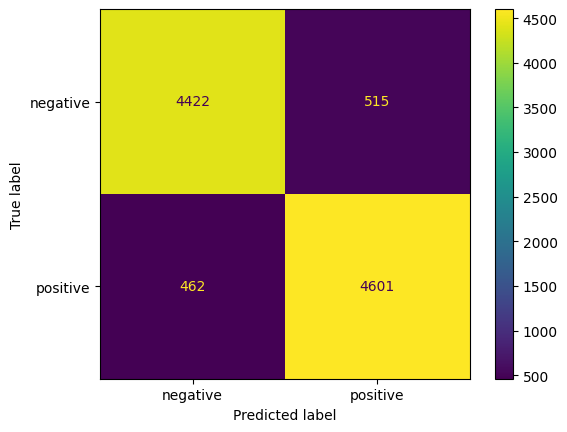

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='viridis')

In [22]:
import pickle
# Save the model with pickle
filename = 'models/sklearn_binary1_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)